In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cross_validation
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
from sklearn.datasets import make_regression, make_friedman1, load_boston

from scipy.stats.mstats import mquantiles
%matplotlib inline

/home/maxim/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Реализация решающего дерева

Мера "нехорошести листа"

In [2]:
def H(target, indexes):
    if indexes.size == 0:
        return 0
    
    y = np.mean([target[i] for i in indexes])
    return np.mean([(target[i] - y)**2 for i in indexes])

In [3]:
# класс, разбивающий лист
# лучшее разбиение выбирается по всем фичам и их квантилям
class Splitter:
    def __init__(self, H):
        self.__H = H
        
    def split(self, data, target, indexes):
        features = [x for x in range(data[0].size)]
        probabilities = np.arange(0.05, 0.95, 0.025)
        quantiles = [mquantiles([data[j][i] for j in indexes], prob = probabilities) for i in features]
        
        # min_params = [min_G, n_feature, step]
        min_params = [self.__G(data, target, indexes, 0, quantiles[0][0]), 0, quantiles[0][0]]
        for i in features:
            for j in quantiles[i]:
                buf = self.__G(data, target, indexes, i, j)
                if buf < min_params[0]:
                    min_params = [buf, i, j]
                    
        l_ind = np.array([x for x in indexes if data[x][min_params[1]] < min_params[2]])
        r_ind = np.array([x for x in indexes if data[x][min_params[1]] >= min_params[2]])
        
        return l_ind, r_ind, min_params[1], min_params[2]
                
    def __G(self, data, target, indexes, n_feature, step):
        l_ind = np.array([x for x in indexes if data[x][n_feature] < step])
        r_ind = np.array([x for x in indexes if data[x][n_feature] >= step])
        
        return (l_ind.size * self.__H(target, l_ind) + r_ind.size * self.__H(target, r_ind))/float(indexes.size)
        

# узел дерева
class TreeNode:
    def __init__(self, indexes = None, left = None, right = None, n_feature = None, step = None):
        self.indexes = indexes
        self.left = left
        self.right = right
        self.n_feature = n_feature
        self.step = step
        
        
# само дерево
class Tree:
    def __init__(self, splitter, data, target, max_depth = None):
        self.__root = TreeNode(data, target)
        self.__splitter = splitter
        self.__data = data
        self.__target = target
        self.__max_depth = max_depth
        
        # рекурсивное построение дерева
        def buildTree(indexes, max_depth):
            if max_depth != None:
                if max_depth == 0:
                    # дальше разбивать нельзя
                    return None, None, None, None
                
            if indexes.size < 0.02 * self.__target.size:
                # дальше разбивать нельзя
                return None, None, None, None
            
            l_ind, r_ind, n_feature, step = splitter.split(self.__data, self.__target, indexes)
            
            if max_depth != None:
                new_ll_tree, new_lr_tree, new_l_n_feature, new_l_step = buildTree(l_ind, max_depth - 1)
                new_rl_tree, new_rr_tree, new_r_n_feature, new_r_step = buildTree(r_ind, max_depth - 1)
            else:
                new_ll_tree, new_lr_tree, new_l_n_feature, new_l_step = buildTree(l_ind, max_depth)
                new_rl_tree, new_rr_tree, new_r_n_feature, new_r_step = buildTree(r_ind, max_depth)
                
            left = TreeNode(l_ind, new_ll_tree, new_lr_tree, new_l_n_feature, new_l_step)
            right = TreeNode(r_ind, new_rl_tree, new_rr_tree, new_r_n_feature, new_r_step)
            
            return left, right, n_feature, step
        
        left, right, n_feature, step = buildTree(indexes = np.array([x for x in range(target.size)]), 
                                                 max_depth = self.__max_depth)
        self.__root = TreeNode(np.array([x for x in range(target.size)]), left, right, n_feature, step)
        
    def predict(self, data):
        if self.__root == None:
            return None
        
        pred = []
        for vec in data:
            node = self.__root
        
            while node != None:
                if node.step == None:
                    break
                
                if vec[node.n_feature] < node.step:
                    node = node.left
                else:
                    node = node.right
                        
            if node == None:
                return None
            else:
                pred.append(np.mean([self.__target[i] for i in node.indexes]))
        
        return np.array(pred)
        
# решающее дерево      
class MyDecisionTree(BaseEstimator):
    def __init__(self, H, max_depth=None):
        self.max_depth = max_depth
        self.splitter = Splitter(H)
        self.tree = None
        
    def fit(self, data, target):
        self.tree = Tree(self.splitter, data, target, self.max_depth)
    
    def predict(self, data):
        return self.tree.predict(np.array(data))

## Загрузка датасета

In [4]:
boston = load_boston()
boston_data = pd.DataFrame(boston.data)
boston_data['target'] = boston.target
boston_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
boston.data[0]

array([  6.32000000e-03,   1.80000000e+01,   2.31000000e+00,
         0.00000000e+00,   5.38000000e-01,   6.57500000e+00,
         6.52000000e+01,   4.09000000e+00,   1.00000000e+00,
         2.96000000e+02,   1.53000000e+01,   3.96900000e+02,
         4.98000000e+00])

In [6]:
train_data, test_data, train_target, test_target = cross_validation.train_test_split(boston.data, boston.target, 
                                                                                     test_size = 0.25)

## Оценка алгоритма

In [7]:
def compareDecisionTrees(depth = None):
    my_DT = MyDecisionTree(H, max_depth = depth)
    my_DT.fit(train_data, train_target)

    DT = DecisionTreeRegressor(max_depth = depth)
    DT.fit(train_data, train_target)
    return mean_squared_error(test_target, my_DT.predict(test_data)), mean_squared_error(test_target, DT.predict(test_data))

In [8]:
depth = [x for x in range(1, 15)]
mse = [[], []]
for i in depth:
    my_tree_mse, tree_mse = compareDecisionTrees(i)
    mse[0].append(my_tree_mse)
    mse[1].append(tree_mse)

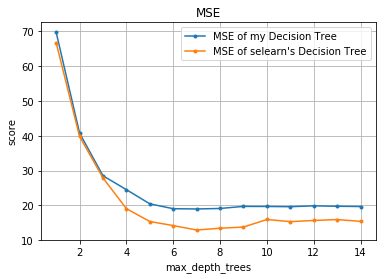

In [9]:
plt.plot(depth, mse[0], marker='.', label='MSE of my Decision Tree')
plt.plot(depth, mse[1], marker='.', label="MSE of selearn's Decision Tree")
plt.grid(True)
plt.xlabel('max_depth_trees')
plt.ylabel('score')
plt.title('MSE')
plt.legend(loc='upper right')

Без ограничения глубины

In [10]:
my_tree_mse, tree_mse = compareDecisionTrees()
print('My DecisionTree: MSE = ', my_tree_mse)
print('Sklearn DecisionTree: MSE = ', tree_mse)

My DecisionTree: MSE =  19.6601424398
Sklearn DecisionTree: MSE =  14.4204724409
